In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from sklearn.ensemble import IsolationForest

In [2]:
!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset

Continuing in background, pid 7711.
Output will be written to ‘wget-log’.


In [4]:
data = np.loadtxt('dataset/sunspots.txt', float)
data_as_frame = pd.DataFrame(data, columns=['Months', 'Sunspots'])
data_as_frame.head()

Months  Sunspots
0     0.0      58.0
1     1.0      62.6
2     2.0      70.0
3     3.0      55.7
4     4.0      85.0

In [5]:
df = data_as_frame
df['Sunspots'].describe()

count    3143.000000
mean       51.924499
std        44.322387
min         0.000000
25%        15.450000
50%        41.500000
75%        76.500000
max       253.800000
Name: Sunspots, dtype: float64

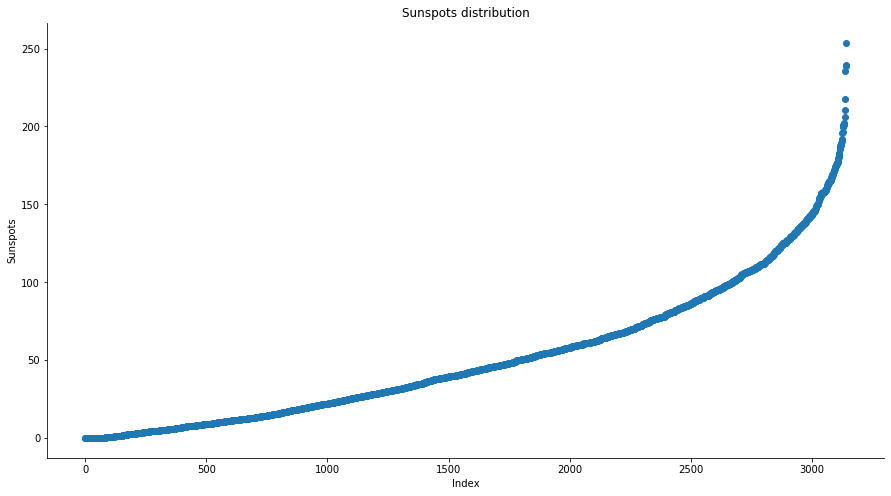

In [6]:
plt.figure(figsize=(15, 8))
plt.scatter(range(df.shape[0]), np.sort(df['Sunspots'].values))
plt.xlabel('Index')
plt.ylabel('Sunspots')
plt.title('Sunspots distribution')
sns.despine()

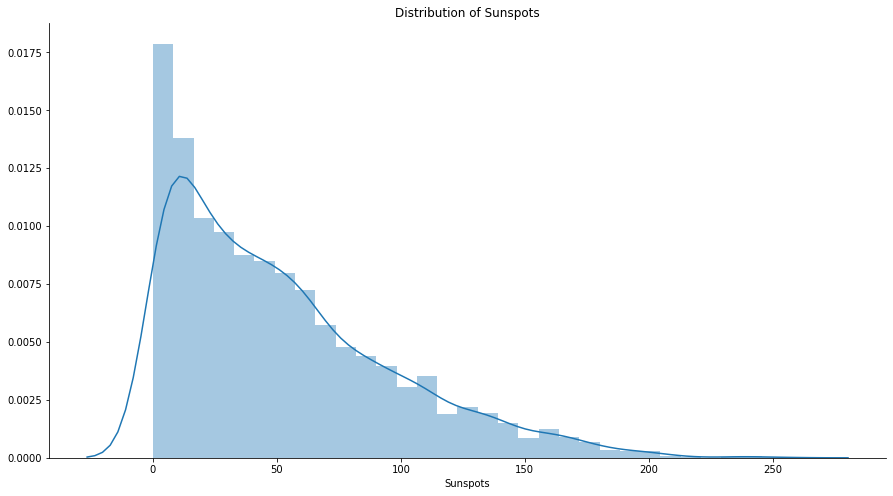

In [7]:
plt.figure(figsize=(15, 8))
sns.distplot(df['Sunspots'])
plt.title('Distribution of Sunspots')
sns.despine()

In [8]:
print(f'Skewness: {df["Sunspots"].skew()}')
print(f'Kurtosis: {df["Sunspots"].kurt()}')

Skewness: 1.0673989214204747
Kurtosis: 0.7663766503824556


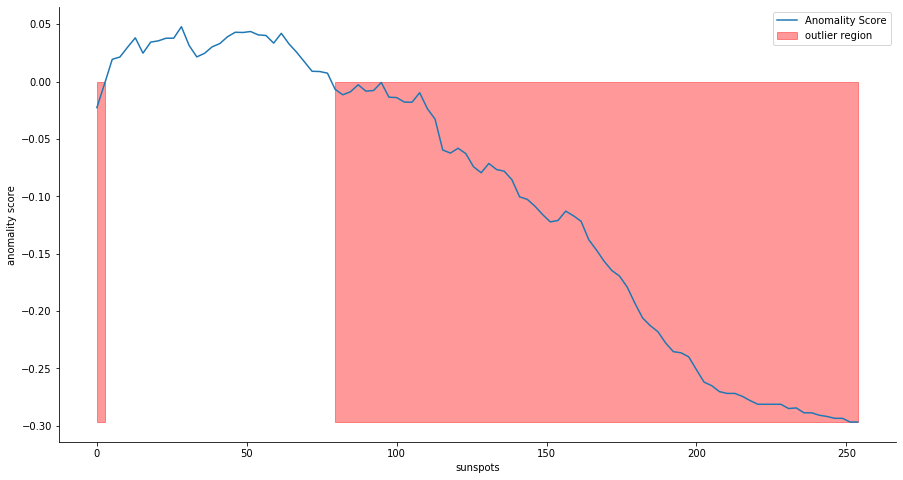

In [9]:
# Spotting outliers using isolation forrest using sklearn ( Univariate )
isolation_forest = IsolationForest(n_estimators=100, contamination='auto', behaviour='new')
isolation_forest.fit(np.array(df['Sunspots']).reshape(-1, 1))

lin_space = np.linspace(start = 0, stop = 253.80, num = 100).reshape(-1,1)
anomality_score = isolation_forest.decision_function(lin_space)
outlier = isolation_forest.predict(lin_space)

plt.figure(figsize=(15, 8))
plt.plot(lin_space, anomality_score, label='Anomality Score')
plt.fill_between(lin_space.T[0], np.min(anomality_score), where=outlier==-1, color='r', alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomality score')
plt.xlabel('sunspots')
sns.despine()
plt.show()

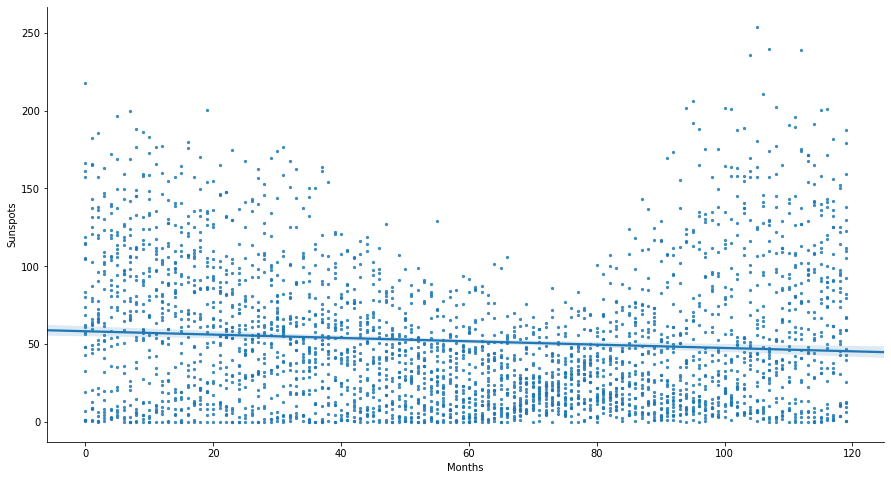

In [58]:
# Outlier detection using PyOD ( Multivariate )

data = np.loadtxt('dataset/sunspots.txt', float)
df = pd.DataFrame(data, columns=['Months', 'Sunspots'])
    
for m in df['Months']:
    df['Months'][m] = m % 120
    
plt.figure(figsize=(15, 8))
sns.regplot(x='Months', y='Sunspots', data=df, scatter_kws={'s':5})
sns.despine()
# print(len(df['Months']))

In [11]:
# Import PyOD models
from pyod.models.abod import ABOD        # Angle-based Outlier Detector
from pyod.models.cblof import CBLOF      # Cluster-based Local Outlier Factor
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS        # Histogram-base Outlier Detection
from pyod.models.iforest import IForest  # Isolation Forest
from pyod.models.knn import KNN          # K Nearest Neighbors
from pyod.models.lof import LOF          # Local Outlier Factor
from pyod.models.mcd import MCD          # Minimum Covariance Determinant
from pyod.models.ocsvm import OCSVM      # One-class SVM
from pyod.models.pca import PCA          # Principal Component Analysis
from pyod.models.lscp import LSCP        # Locally Selective Combination

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
10 fitting One-class SVM (OCSVM)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)


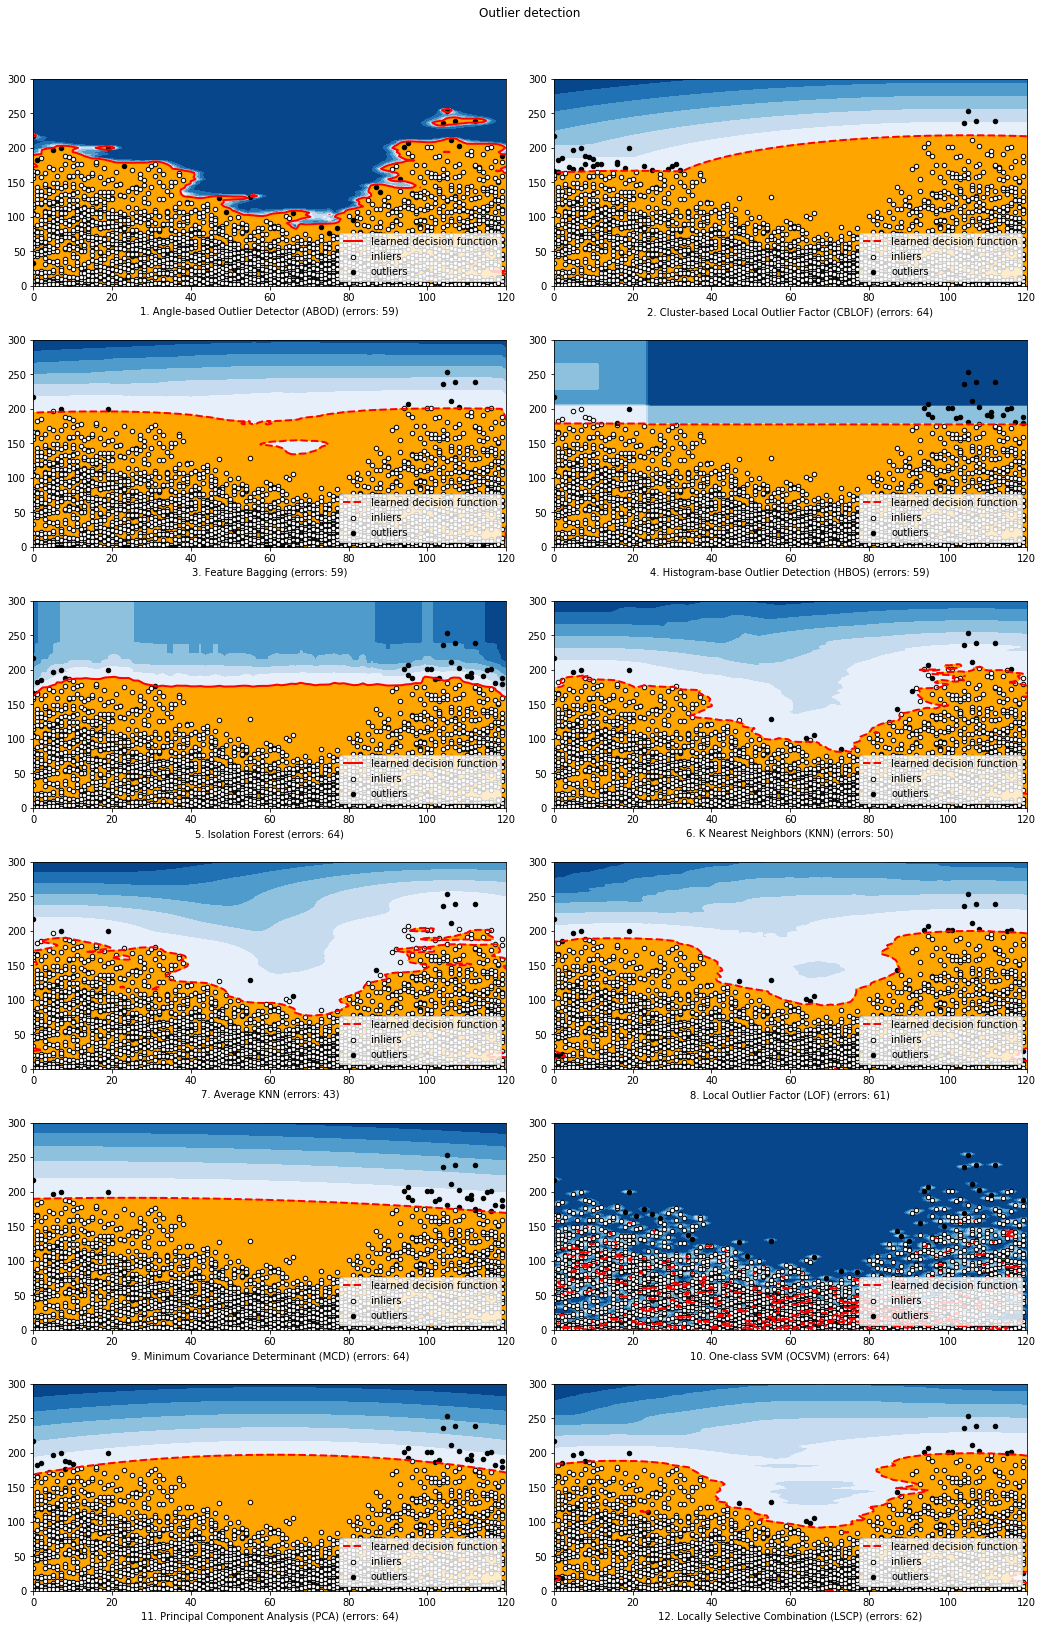

In [59]:
n_samples = 3143
outliers_fraction = 0.01
clusters_separation = [0]
x_axis, y_axis = 120, 300

xx, yy = np.meshgrid(np.linspace(0, x_axis, 100), np.linspace(0, y_axis, 100))
# n_inliers = int((1. - outliers_fraction) * n_samples)
# n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

X1 = df['Months'].values.reshape(-1,1)
X2 = df['Sunspots'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)


random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state, behaviour="new"),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

for i, offset in enumerate(clusters_separation):
    plt.figure(figsize=(15, 25))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        
        
        dfx = df
        dfx['outlier'] = y_pred.tolist()
        
        IX1 = np.array(dfx['Months'][dfx['outlier'] == 0]).reshape(-1, 1)
        IX2 = np.array(dfx['Sunspots'][dfx['outlier'] == 0]).reshape(-1, 1)
        
        OX1 = np.array(dfx['Months'][dfx['outlier'] == 1]).reshape(-1, 1)
        OX2 = np.array(dfx['Sunspots'][dfx['outlier'] == 1]).reshape(-1, 1)
        
        
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(6, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(IX1, IX2, c='white', s=20, edgecolor='k')
        c = subplot.scatter(OX1, OX2, c='black', s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b , c],
            ['learned decision function', 'inliers', 'outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((0, x_axis))
        subplot.set_ylim((0, y_axis))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()